# Project - Solar Energy Production Forecasting
## Part 1 - Load data + EDA

Steps:
- Load train and test datasets
- Ensure chronological order (no shuffling)
- Create a 70/30 Train/Validation split **by time**
- Perform minimal sanity checks (shape, missing values, target leakage)

### Import Packages

In [2]:
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict

### Load Datasets

In [3]:
#loading datasets and basic checks
TRAIN_URL = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Train.csv"
TEST_URL  = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Test.csv"

train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

display(train_df.head())
display(test_df.head())

Train shape: (176505, 17)
Test shape : (59376, 17)


,UTC Time,Plant_ID,Energy_Production,Benchmark,Day-Night,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
0,2020-01-04 00:00:00+00:00,0,0.0,0.0,N,4.0,1.23,17.21,1.0,0.0,0.0,2.5,277.0,0,2.0,84.0,5.04
1,2020-01-04 01:00:00+00:00,0,0.0,0.0,N,4.0,0.28,17.39,1.0,0.0,-0.3,1.8,290.0,0,2.0,86.0,5.40
2,2020-01-04 02:00:00+00:00,0,0.0,0.0,N,4.0,-0.89,18.57,0.0,0.0,-0.7,0.9,297.0,0,2.0,89.0,5.76
3,2020-01-04 03:00:00+00:00,0,0.0,0.0,N,4.0,-1.96,19.75,0.0,0.0,-1.1,0.1,300.0,0,2.0,92.0,6.12
4,2020-01-04 04:00:00+00:00,0,0.0,0.0,N,3.0,-2.30,19.93,0.0,0.0,-1.4,-0.2,299.0,0,2.0,92.0,6.12


,UTC Time,Plant_ID,Energy_Production,Benchmark,Day-Night,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
0,2021-08-26 00:00:00+00:00,0,0.004,0.004,N,8.0,17.50,21.32,0.0,0.0,13.1,17.5,345.0,0,7.0,76.0,6.48
1,2021-08-26 01:00:00+00:00,0,0.004,0.004,N,8.0,17.10,19.41,0.0,0.0,13.0,17.1,341.0,0,7.0,77.0,6.12
2,2021-08-26 02:00:00+00:00,0,0.004,0.004,N,6.0,16.50,20.50,0.0,0.0,12.8,16.5,341.0,0,7.0,79.0,5.76
3,2021-08-26 03:00:00+00:00,0,0.004,0.004,N,6.0,15.80,20.58,0.0,0.0,12.6,15.8,342.0,0,7.0,81.0,5.40
4,2021-08-26 04:00:00+00:00,0,0.004,0.004,D,6.0,15.65,22.67,0.0,0.0,12.5,15.2,359.0,0,8.0,84.0,5.04


### Parse dates and check `NaNs`

In [4]:
time_col = 'UTC Time'

train_df[time_col] = pd.to_datetime(train_df[time_col], errors="coerce")
test_df[time_col]  = pd.to_datetime(test_df[time_col], errors="coerce")

train_df = train_df.sort_values(time_col).reset_index(drop=True)
test_df  = test_df.sort_values(time_col).reset_index(drop=True)

In [5]:
#checking for missing values

def missing_report(df, name='df'):
    miss = df.isna().mean().sort_values(ascending=False)
    miss = miss[miss>0]
    print(f"\nMissingness report — {name}")
    if len(miss) == 0:
        print("No missing values")
        return
    display((miss * 100) * 100).round(2).to_frame('% of missing values')

missing_report(train_df, "train_df")
missing_report(test_df, "test_df")


Missingness report — train_df
No missing values

Missingness report — test_df
No missing values


### Joining both datasets for a more in depht EDA

In [6]:
#joining both dfs for EDA
df = pd.concat([train_df, test_df], join="inner").sort_values("UTC Time").sort_values("Plant_ID")
df.shape

(235881, 17)

In [7]:
df.describe()

,Plant_ID,Energy_Production,Benchmark,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
count,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,2.358810e+05,235881.000000,235881.000000,235881.000000
mean,7.670859,0.008685,0.008677,6.076560,11.535787,18.994054,10.469979,0.010241,6.796013,12.109901,143.582056,-3.277474e+06,9.581433,72.889347,7.436998
std,4.577249,0.014589,0.014576,1.945064,9.347031,8.756769,17.102289,0.040474,6.631462,8.387371,114.718993,8.383085e+07,4.858372,16.940525,2.438261
min,0.000000,0.000000,0.000000,3.000000,-10.240000,0.000000,0.000000,0.000000,-13.100000,-7.600000,0.000000,-2.147484e+09,1.000000,15.000000,0.160000
25%,4.000000,0.000000,0.000000,4.000000,4.200000,14.000000,1.000000,0.000000,1.800000,5.500000,37.000000,0.000000e+00,7.000000,61.000000,5.760000
50%,8.000000,0.000000,0.000000,6.000000,9.960000,19.090000,4.000000,0.000000,6.200000,10.700000,112.000000,0.000000e+00,8.000000,77.000000,7.200000
75%,12.000000,0.012000,0.012000,8.000000,18.300000,23.260000,9.000000,0.000000,12.100000,18.300000,231.000000,0.000000e+00,15.000000,87.000000,8.640000
max,15.000000,0.097000,0.097000,12.000000,39.840000,73.850000,84.000000,0.650000,22.700000,35.600000,359.000000,4.600000e+01,18.000000,99.000000,27.000000


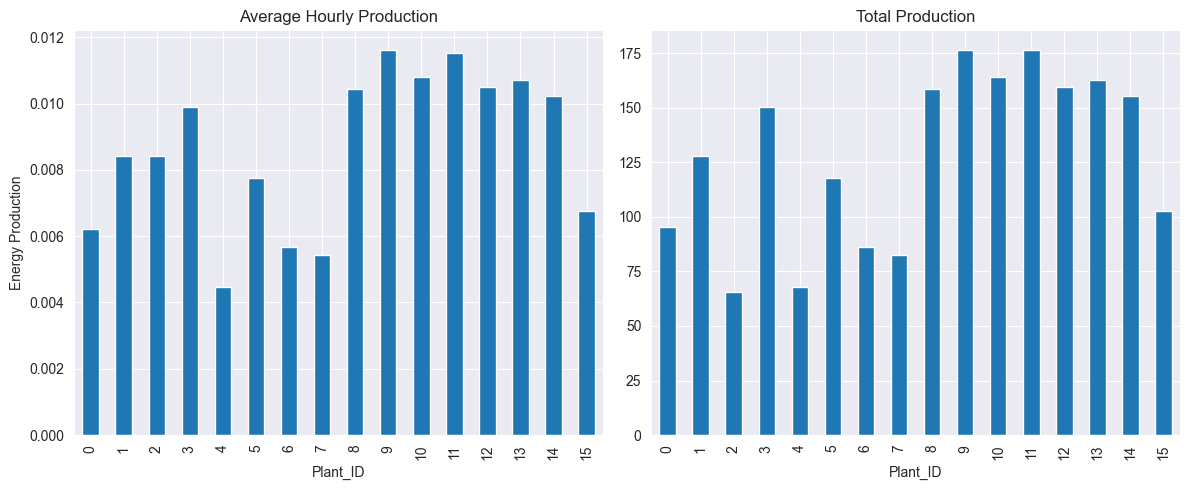

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

df.groupby('Plant_ID')['Energy_Production'].mean().plot(kind='bar', ax=axes[0], title="Average Hourly Production")
axes[0].set_ylabel("Energy Production")

df.groupby('Plant_ID')['Energy_Production'].sum().plot(kind='bar', ax=axes[1], title="Total Production")
plt.tight_layout()
plt.show()

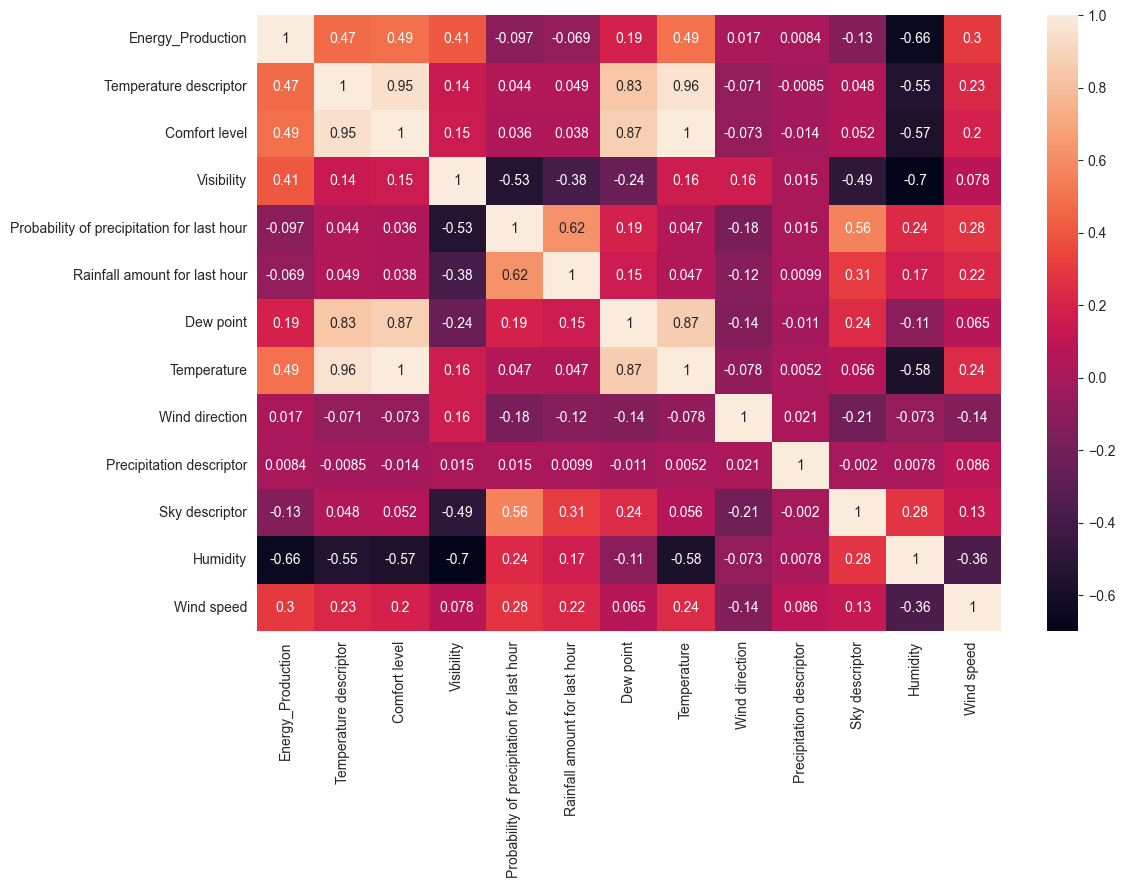

In [9]:
import seaborn as sns

corr = df[['Energy_Production',
       'Temperature descriptor', 'Comfort level', 'Visibility',
       'Probability of precipitation for last hour',
       'Rainfall amount for last hour', 'Dew point', 'Temperature',
       'Wind direction', 'Precipitation descriptor', 'Sky descriptor',
       'Humidity', 'Wind speed']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True)
plt.show()

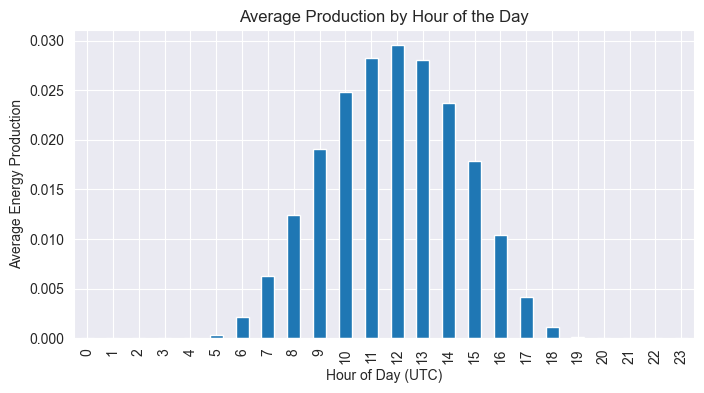

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))

df['UTC Time'] = pd.to_datetime(df['UTC Time'])
df['hour'] = df['UTC Time'].dt.hour

(
    df.groupby('hour')['Energy_Production']
      .mean()
      .plot(
          kind='bar',
          ax=ax,
          title="Average Production by Hour of the Day"
      )
)

ax.set_xlabel("Hour of Day (UTC)")
ax.set_ylabel("Average Energy Production")
plt.show()

### Variance by plant

In [11]:
plant_variance = (df.groupby('Plant_ID')['Energy_Production'].agg(
          variance='var',
          std='std',
          mean='mean',
          count='count')
      .sort_values('variance', ascending=False))

display(plant_variance)

,variance,std,mean,count
Plant_ID,,,,
9,0.000338,0.018372,0.011623,15191
11,0.000325,0.018034,0.011523,15311
13,0.000295,0.017163,0.010709,15191
10,0.000292,0.017080,0.010802,15191
8,0.000278,0.016684,0.010434,15191
12,0.000275,0.016571,0.010493,15191
14,0.000264,0.016245,0.010231,15191
3,0.000258,0.016059,0.009881,15191
1,0.000192,0.013864,0.008413,15191


# Part 2 Feature Engineering

### Cyclical Feature Encoding

Some variables represent cyclical phenomena rather than linear quantities.

- Hour of day (0–23) is cyclical: hour 23 is close to hour 0.
- Wind direction (0–359°) is circular: 359° is close to 0°.

To preserve this structure, we apply sine and cosine transformations. This allows machine learning models to learn smooth periodic patterns
without artificial discontinuities.

In [12]:
# Cyclical encoding: hour of day
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Cyclical encoding: wind direction (degrees)
df['wind_dir_rad'] = np.deg2rad(df['Wind direction'])
df['wind_dir_sin'] = np.sin(df['wind_dir_rad'])
df['wind_dir_cos'] = np.cos(df['wind_dir_rad'])

# Drop intermediate column
df.drop(columns=['wind_dir_rad'], inplace=True)

In [13]:
# Ensure proper ordering
df = df.sort_values(['Plant_ID', 'UTC Time']).reset_index(drop=True)

### Panel-Safe Lag and Rolling Features

The dataset is panel data, with observations indexed by `Plant_ID` and `UTC time`. To avoid data leakage:
- All lagged and rolling features are computed **for each plant**
- Rolling statistics only use **past values** via a shift
- The data is sorted by time before feature construction

These features allow the model to capture short-term persistence and
local trends in energy production.


In [25]:
def add_time_and_cyclical_features(d):
    d = d.copy()
    d["UTC Time"] = pd.to_datetime(d["UTC Time"])
    d["hour"] = d["UTC Time"].dt.hour

    d["hour_sin"] = np.sin(2 * np.pi * d["hour"] / 24)
    d["hour_cos"] = np.cos(2 * np.pi * d["hour"] / 24)

    d["wind_dir_sin"] = np.sin(np.deg2rad(d["Wind direction"]))
    d["wind_dir_cos"] = np.cos(np.deg2rad(d["Wind direction"]))
    return d

def add_panel_lags_and_rolls(d, lags=(1,3,6,12,24), windows=(3,6,12,24)):
    d = d.copy()
    d = d.sort_values(["Plant_ID", "UTC Time"]).reset_index(drop=True)

    for lag in lags:
        d[f"Energy_Production_lag_{lag}"] = d.groupby("Plant_ID")["Energy_Production"].shift(lag)

    for w in windows:
    d[f"EP_roll_mean_{w}"] = (
        d.groupby("Plant_ID")["Energy_Production"]
         .apply(lambda s: s.shift(1).rolling(w).mean())
         .reset_index(level=0, drop=True)
    )
    d[f"EP_roll_std_{w}"] = (
        d.groupby("Plant_ID")["Energy_Production"]
         .apply(lambda s: s.shift(1).rolling(w).std())
         .reset_index(level=0, drop=True)
    )
    return d

train_feat = add_panel_lags_and_rolls(add_time_and_cyclical_features(train_raw))
test_feat  = add_panel_lags_and_rolls(add_time_and_cyclical_features(test_raw))


### PCA on Weather Features

Weather variables exhibit strong multicollinearity.We apply Principal Component Analysis (PCA) to continuous weather features only.

Steps:
- Standardize all features
- Retain components explaining 95% of total variance
- Replace original weather variables with PCA components

This reduces dimensionality while preserving most of the information, and allows us to compare model performance with and without PCA.


# Step 3 — Model Selection & Tuning

In this step we:
1. Build a leakage proof Train/Validation split (no shuffling, last 30% as validation).
2. Compare multiple model families:
   - Linear: Ridge, Lasso
   - Distance-based: KNN
   - Tree-based: Random Forest
   - Boosting: Gradient Boosting (baseline boosting)
3. Evaluate all models using:
   - RMSE (lower is better)
   - R² (higher is better)

We implement the two strategies:
- **Global Model**: one model trained on all plants using `Plant_ID` as a feature.
- **Local Models**: one model per `Plant_ID` (15 separate models), then aggregate performance.

In [23]:
# re-separating datasets
train_raw = train_df.copy()
test_raw  = test_df.copy()

# Ensure sorted for time  consistency
train_raw = train_raw.sort_values(["UTC Time", "Plant_ID"]).reset_index(drop=True)
test_raw  = test_raw.sort_values(["UTC Time", "Plant_ID"]).reset_index(drop=True)

### Implementing Global Models

In [41]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

TARGET_COL = "Energy_Production"
BENCH_COL  = "Benchmark"
TIME_COL   = "UTC Time"

# Feature columns: drop target, benchmark & time
drop_cols = [TARGET_COL, BENCH_COL, TIME_COL]
feature_cols_eval = [c for c in train_feat.columns if c not in drop_cols]

# X/y
X_train = train_feat[feature_cols_eval].copy()
y_train = train_feat[TARGET_COL].copy()

X_test  = test_feat[feature_cols_eval].copy()
y_test  = test_feat[TARGET_COL].copy()

# Numeric/categorical split
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

# Preprocess
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95, random_state=42))
])
categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, numeric_cols),
        ("cat", categorical_preprocess, categorical_cols)
    ]
)

# Models + grids (your set)
models = {
    "Ridge": Pipeline([("prep", preprocess), ("model", Ridge(random_state=42))]),
    "Lasso": Pipeline([("prep", preprocess), ("model", Lasso(random_state=42, max_iter=20000))]),
    "KNN": Pipeline([("prep", preprocess), ("model", KNeighborsRegressor())]),
    "RandomForest": Pipeline([("prep", preprocess), ("model", RandomForestRegressor(random_state=42, n_jobs=-1))]),
    "GradBoost": Pipeline([("prep", preprocess), ("model", GradientBoostingRegressor(random_state=42))]),
}

param_grids = {
    "Ridge": {"model__alpha": [0.1, 1.0, 10.0, 100.0]},
    "Lasso": {"model__alpha": [1e-4, 1e-3, 1e-2, 1e-1]},
    "KNN":   {"model__n_neighbors": [5, 15, 30], "model__weights": ["uniform", "distance"]},
    "RandomForest": {"model__n_estimators": [200], "model__max_depth": [None, 10, 20]},
    "GradBoost": {"model__n_estimators": [200], "model__learning_rate": [0.05, 0.1], "model__max_depth": [2, 3]},
}

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def eval_train_test(fitted, Xtr, ytr, Xte, yte):
    pred_tr = np.clip(fitted.predict(Xtr), 0, None)
    pred_te = np.clip(fitted.predict(Xte), 0, None)
    return (
        rmse(ytr, pred_tr), float(r2_score(ytr, pred_tr)),
        rmse(yte, pred_te), float(r2_score(yte, pred_te)),
        pred_te
    )

# TimeSeries CV for tuning
tscv = TimeSeriesSplit(n_splits=3)

rows = []
test_predictions = {}  # store predictions for plotting later

for name, pipe in models.items():
    grid = GridSearchCV(
        pipe,
        param_grids[name],
        scoring="neg_root_mean_squared_error",
        cv=tscv,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best = grid.best_estimator_

    rmse_tr, r2_tr, rmse_te, r2_te, pred_te = eval_train_test(best, X_train, y_train, X_test, y_test)
    test_predictions[name] = pred_te

    rows.append({
        "model": name,
        "rmse_train": rmse_tr,
        "r2_train": r2_tr,
        "rmse_test": rmse_te,
        "r2_test": r2_te,
        "best_params": grid.best_params_
    })

results_all = pd.DataFrame(rows).sort_values("rmse_test").reset_index(drop=True)

# Benchmark metrics (train + test)
bench_train = np.clip(train_feat[BENCH_COL].values, 0, None)
bench_test  = np.clip(test_feat[BENCH_COL].values, 0, None)

bench_row = {
    "model": "Benchmark",
    "rmse_train": rmse(y_train, bench_train),
    "r2_train": float(r2_score(y_train, bench_train)),
    "rmse_test": rmse(y_test, bench_test),
    "r2_test": float(r2_score(y_test, bench_test)),
    "best_params": None
}

results_all = pd.concat([results_all, pd.DataFrame([bench_row])], ignore_index=True)
results_all = results_all.sort_values("rmse_test").reset_index(drop=True)

# Improvement vs benchmark on test
rmse_bench_test = bench_row["rmse_test"]
results_all["rmse_improve_vs_bench_%"] = 100 * (rmse_bench_test - results_all["rmse_test"]) / rmse_bench_test

display(results_all)

,model,rmse_train,r2_train,rmse_test,r2_test,best_params,rmse_improve_vs_bench_%
0,RandomForest,8.668965e-04,0.996828,0.003567,0.903834,"{'model__max_depth': None, 'model__n_estimator...",49.526688
1,GradBoost,3.859526e-03,0.937118,0.003691,0.897032,"{'model__learning_rate': 0.1, 'model__max_dept...",47.772320
2,KNN,5.837723e-10,1.000000,0.003802,0.890719,"{'model__n_neighbors': 5, 'model__weights': 'd...",46.195055
3,Lasso,4.398873e-03,0.918315,0.003943,0.882500,{'model__alpha': 0.0001},44.208300
4,Ridge,4.377687e-03,0.919100,0.003969,0.880947,{'model__alpha': 0.1},43.840730
5,Benchmark,7.659262e-03,0.752354,0.007067,0.622516,None,0.000000


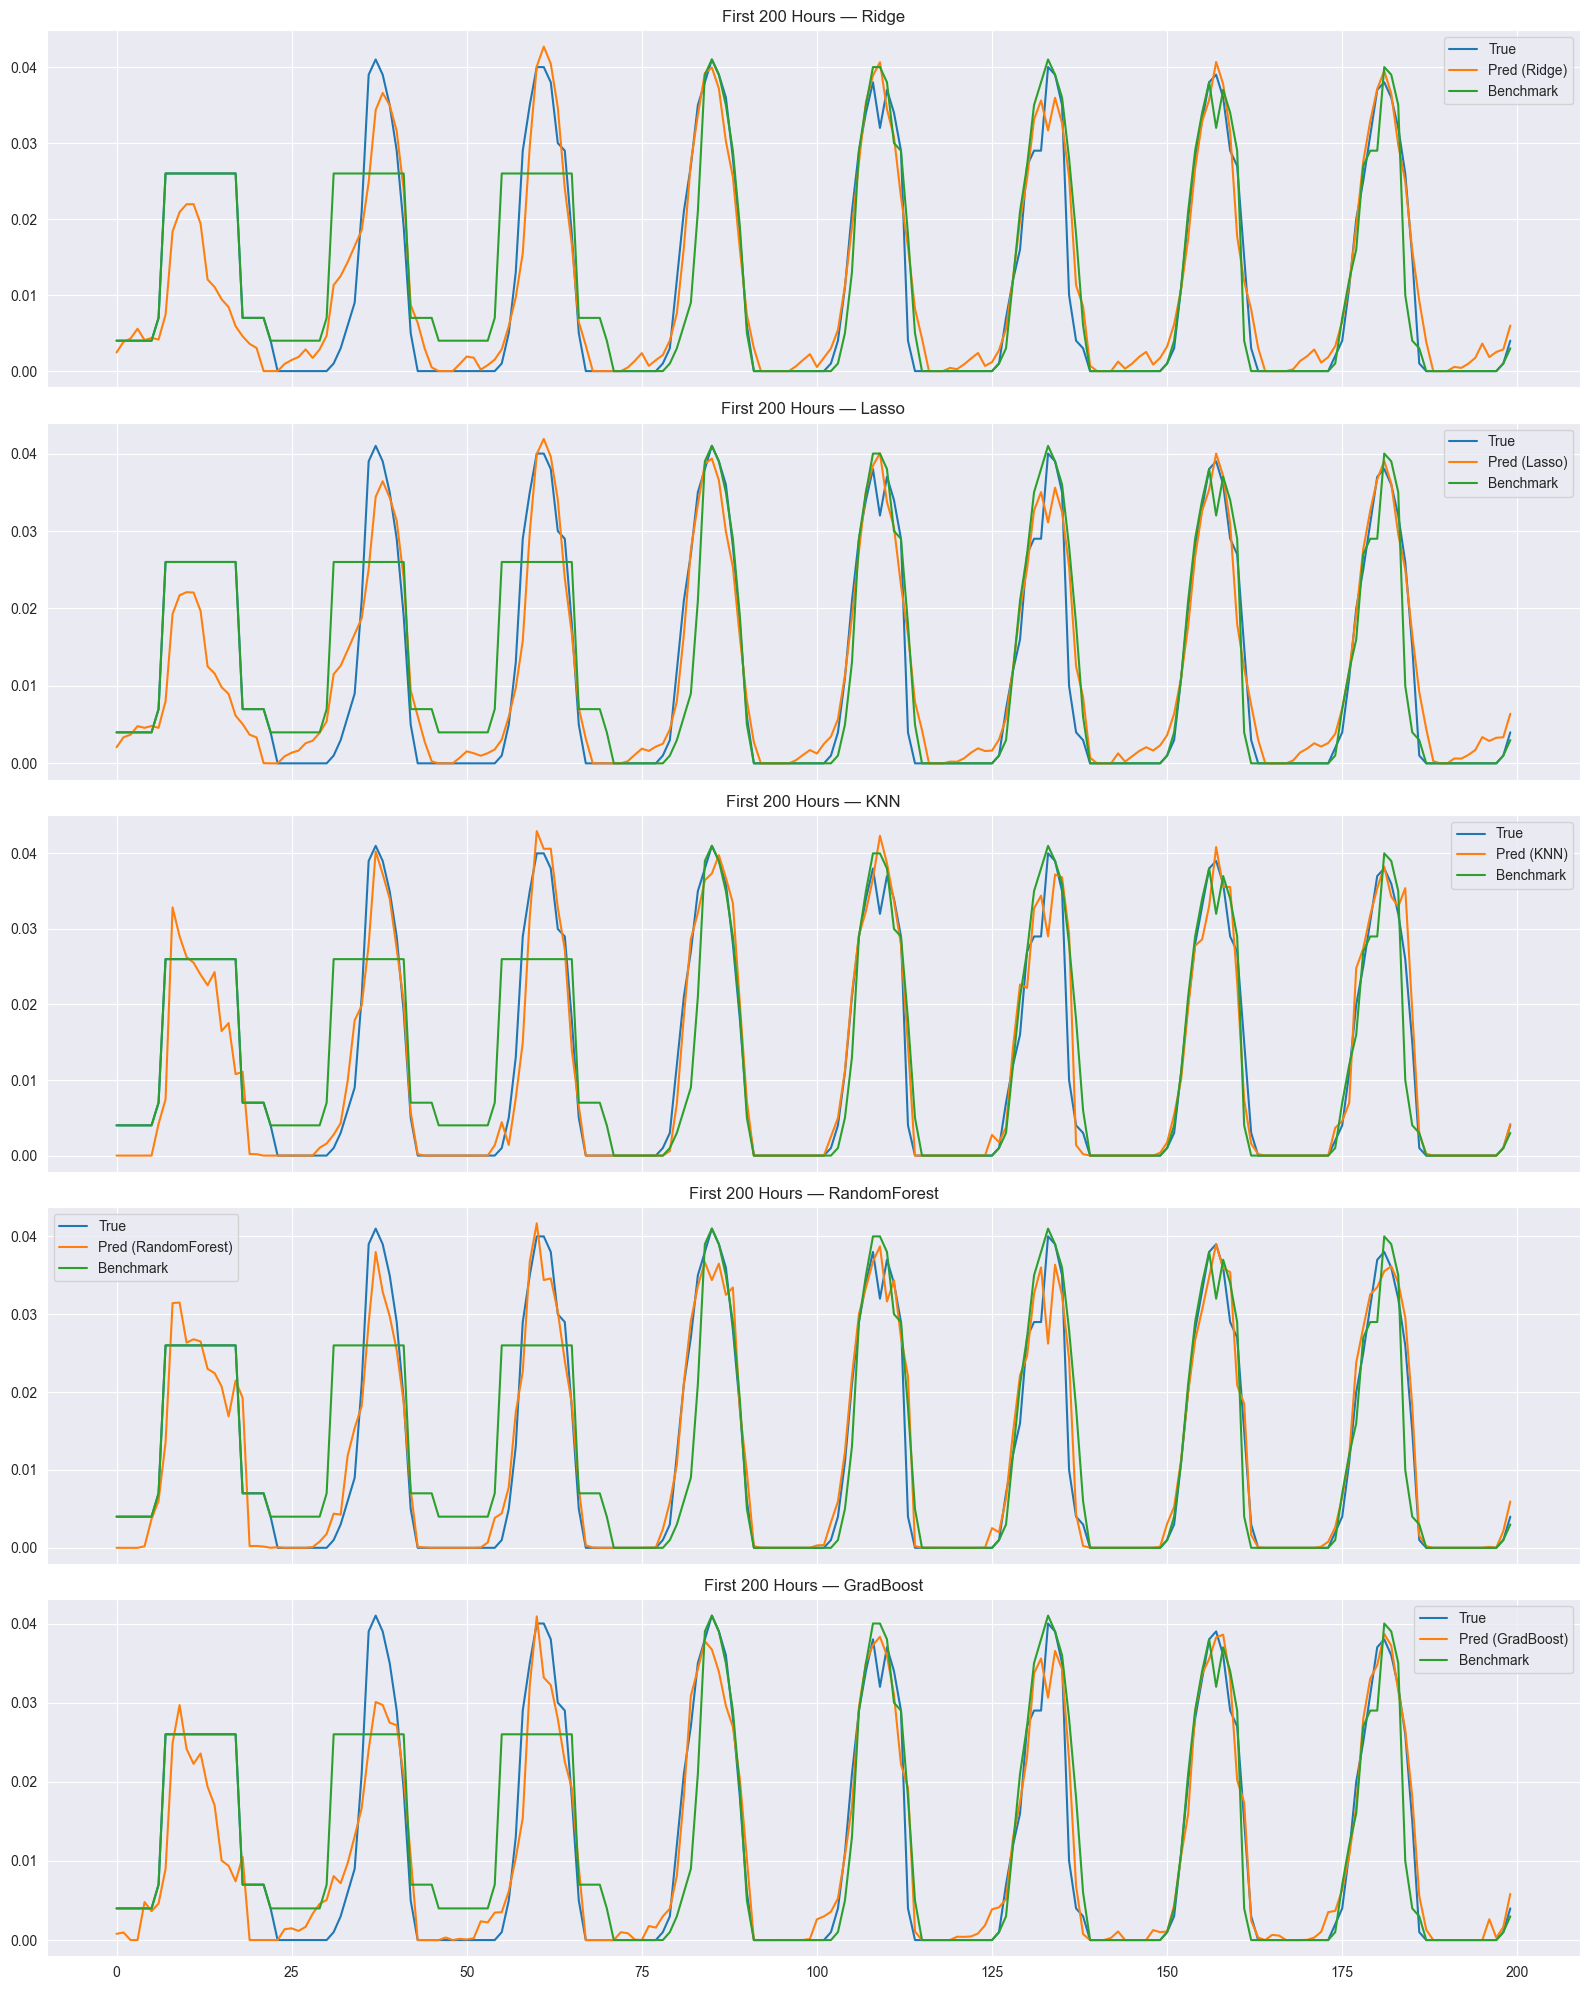

In [42]:
models_to_plot = [m for m in test_predictions.keys()]  # all ML models
n = 200
y_true = y_test.values[:n]
y_bench = np.clip(test_feat[BENCH_COL].values[:n], 0, None)

fig, axes = plt.subplots(len(models_to_plot), 1, figsize=(16, 4*len(models_to_plot)), sharex=True)

if len(models_to_plot) == 1:
    axes = [axes]

for ax, m in zip(axes, models_to_plot):
    ax.plot(y_true, label="True")
    ax.plot(test_predictions[m][:n], label=f"Pred ({m})")
    ax.plot(y_bench, label="Benchmark")
    ax.set_title(f"First {n} Hours — {m}")
    ax.legend()

plt.tight_layout()
plt.show()

### Implementing Local Models

In [44]:
### Implementing Local Models (FIXED: pipeline matches local_feature_cols)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

PLANT_COL = "Plant_ID"

# Local features: remove Plant_ID because within plant it is constant
local_feature_cols = [c for c in feature_cols_eval if c != PLANT_COL]

# Build X/y "templates" for dtype detection (important!)
X_local_template = train_feat[local_feature_cols].copy()

# Numeric/categorical split for LOCAL feature set
local_numeric_cols = X_local_template.select_dtypes(include=[np.number]).columns.tolist()
local_categorical_cols = [c for c in X_local_template.columns if c not in local_numeric_cols]

# LOCAL preprocess (same logic, but columns aligned to local_feature_cols)
local_numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95, random_state=42))
])

local_categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

local_preprocess = ColumnTransformer(
    transformers=[
        ("num", local_numeric_preprocess, local_numeric_cols),
        ("cat", local_categorical_preprocess, local_categorical_cols)
    ]
)

# LOCAL models (use local_preprocess)
local_models = {
    "Ridge": Pipeline([("prep", local_preprocess), ("model", Ridge(random_state=42))]),
    "Lasso": Pipeline([("prep", local_preprocess), ("model", Lasso(random_state=42, max_iter=20000))]),
    "KNN": Pipeline([("prep", local_preprocess), ("model", KNeighborsRegressor())]),
    "RandomForest": Pipeline(
        [("prep", local_preprocess), ("model", RandomForestRegressor(random_state=42, n_jobs=-1))]),
    "GradBoost": Pipeline([("prep", local_preprocess), ("model", GradientBoostingRegressor(random_state=42))]),
}

# Same grids as before
local_param_grids = param_grids

# Time-series CV for tuning within each plant
tscv_local = TimeSeriesSplit(n_splits=3)

local_rows = []
local_test_predictions = {}

plant_ids = sorted(train_feat[PLANT_COL].unique())

for pid in plant_ids:
    tr_p = train_feat[train_feat[PLANT_COL] == pid].sort_values("UTC Time")
    te_p = test_feat[test_feat[PLANT_COL] == pid].sort_values("UTC Time")

    if len(tr_p) < 200 or len(te_p) < 50:
        print(f"Skipping Plant {pid} (train={len(tr_p)}, test={len(te_p)})")
        continue

    X_tr = tr_p[local_feature_cols].copy()
    y_tr = tr_p[TARGET_COL].copy()

    X_te = te_p[local_feature_cols].copy()
    y_te = te_p[TARGET_COL].copy()

    for model_name, pipe in local_models.items():
        grid = GridSearchCV(
            estimator=pipe,
            param_grid=local_param_grids[model_name],
            scoring="neg_root_mean_squared_error",
            cv=tscv_local,
            n_jobs=-1
        )
        grid.fit(X_tr, y_tr)
        best = grid.best_estimator_

        pred_tr = np.clip(best.predict(X_tr), 0, None)
        pred_te = np.clip(best.predict(X_te), 0, None)

        local_rows.append({
            "Plant_ID": pid,
            "model": f"Local-{model_name}",
            "rmse_train": rmse(y_tr, pred_tr),
            "r2_train": float(r2_score(y_tr, pred_tr)),
            "rmse_test": rmse(y_te, pred_te),
            "r2_test": float(r2_score(y_te, pred_te)),
            "best_params": grid.best_params_
        })

        local_test_predictions[(pid, model_name)] = {
            "y_true": y_te.values,
            "y_pred": pred_te,
            "utc_time": te_p["UTC Time"].values,
            "benchmark": np.clip(te_p["Benchmark"].values, 0, None) if "Benchmark" in te_p.columns else None
        }

local_results_df = pd.DataFrame(local_rows).sort_values(["Plant_ID", "rmse_test"])
display(local_results_df)


,Plant_ID,model,rmse_train,r2_train,rmse_test,r2_test,best_params
2,0,Local-KNN,1.367863e-09,1.000000,0.002246,0.923000,"{'model__n_neighbors': 15, 'model__weights': '..."
3,0,Local-RandomForest,1.059478e-03,0.991061,0.002318,0.917983,"{'model__max_depth': None, 'model__n_estimator..."
4,0,Local-GradBoost,2.525878e-03,0.949194,0.002328,0.917251,"{'model__learning_rate': 0.1, 'model__max_dept..."
0,0,Local-Ridge,3.250909e-03,0.915841,0.002506,0.904145,{'model__alpha': 100.0}
1,0,Local-Lasso,1.120613e-02,0.000000,0.008440,-0.087489,{'model__alpha': 0.1}
...,...,...,...,...,...,...,...
77,15,Local-KNN,2.451286e-09,1.000000,0.002472,0.915335,"{'model__n_neighbors': 30, 'model__weights': '..."
78,15,Local-RandomForest,1.016177e-03,0.991833,0.002548,0.910052,"{'model__max_depth': None, 'model__n_estimator..."
79,15,Local-GradBoost,2.732797e-03,0.940930,0.002665,0.901602,"{'model__learning_rate': 0.05, 'model__max_dep..."
75,15,Local-Ridge,3.185192e-03,0.919755,0.002781,0.892887,{'model__alpha': 100.0}


#### A) Average metrics per model family across plants

In [45]:
local_summary_by_model = (
    local_results_df
    .groupby("model")[["rmse_train", "r2_train", "rmse_test", "r2_test"]]
    .mean()
    .sort_values("rmse_test")
)

display(local_summary_by_model)

,rmse_train,r2_train,rmse_test,r2_test
model,,,,
Local-KNN,2.614267e-09,1.000000,0.003414,0.898441
Local-RandomForest,1.326798e-03,0.991918,0.003416,0.898019
Local-GradBoost,3.451762e-03,0.944751,0.003608,0.887002
Local-Ridge,4.204988e-03,0.919484,0.003736,0.881194
Local-Lasso,1.409044e-02,0.057059,0.010968,-0.066915


#### B) Best local model per plant (select by lowest test RMSE)

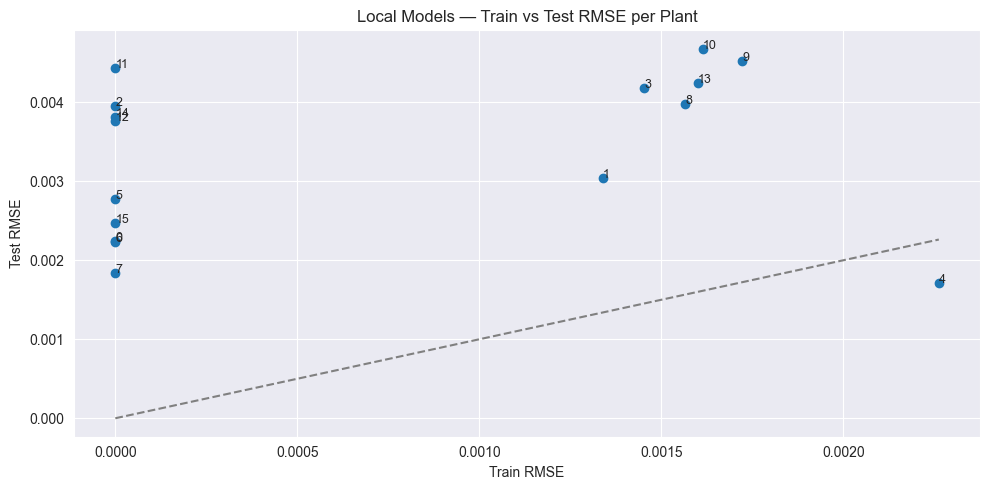

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(best_local_per_plant["rmse_train"], best_local_per_plant["rmse_test"])

for _, row in best_local_per_plant.iterrows():
    ax.text(row["rmse_train"], row["rmse_test"], str(int(row["Plant_ID"])), fontsize=9)

ax.plot(
    [best_local_per_plant["rmse_train"].min(), best_local_per_plant["rmse_train"].max()],
    [best_local_per_plant["rmse_train"].min(), best_local_per_plant["rmse_train"].max()],
    linestyle="--", color="gray"
)

ax.set_xlabel("Train RMSE")
ax.set_ylabel("Test RMSE")
ax.set_title("Local Models — Train vs Test RMSE per Plant")
plt.tight_layout()
plt.show()

#### C) “Local strategy overall score” (mean of best per-plant models)

In [47]:
local_best_overall = best_local_per_plant[["rmse_train", "r2_train", "rmse_test", "r2_test"]].mean()
print("Local strategy (best-per-plant average):")
display(local_best_overall.to_frame("mean_metric"))

Local strategy (best-per-plant average):


,mean_metric
rmse_train,0.000722
r2_train,0.992342
rmse_test,0.003367
r2_test,0.901755


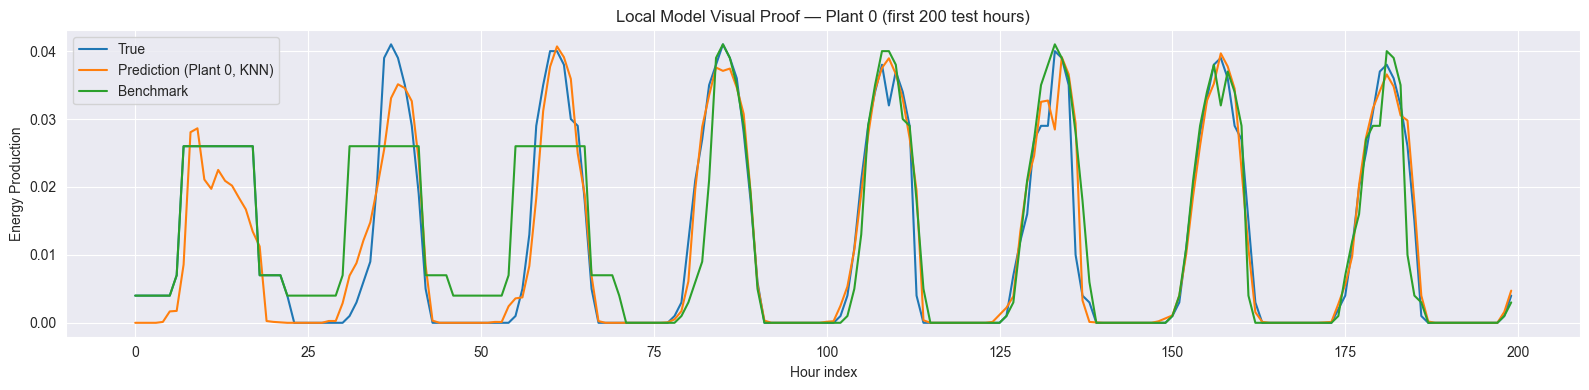

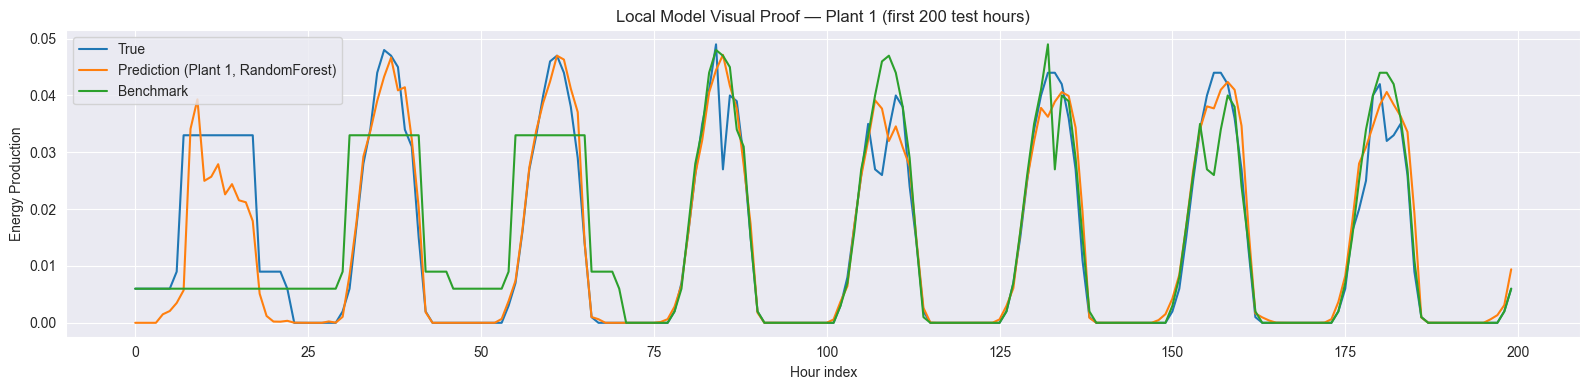

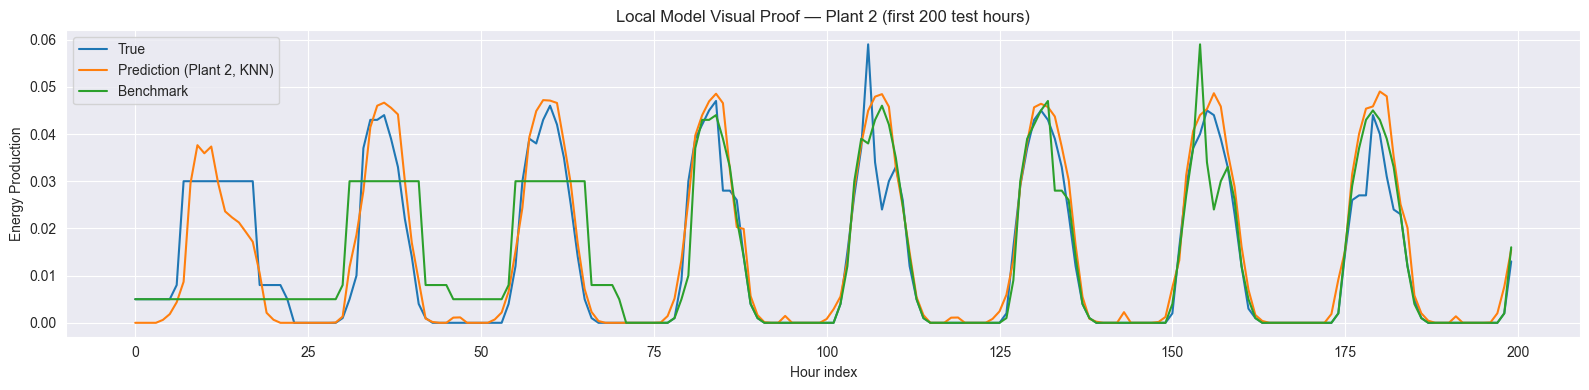

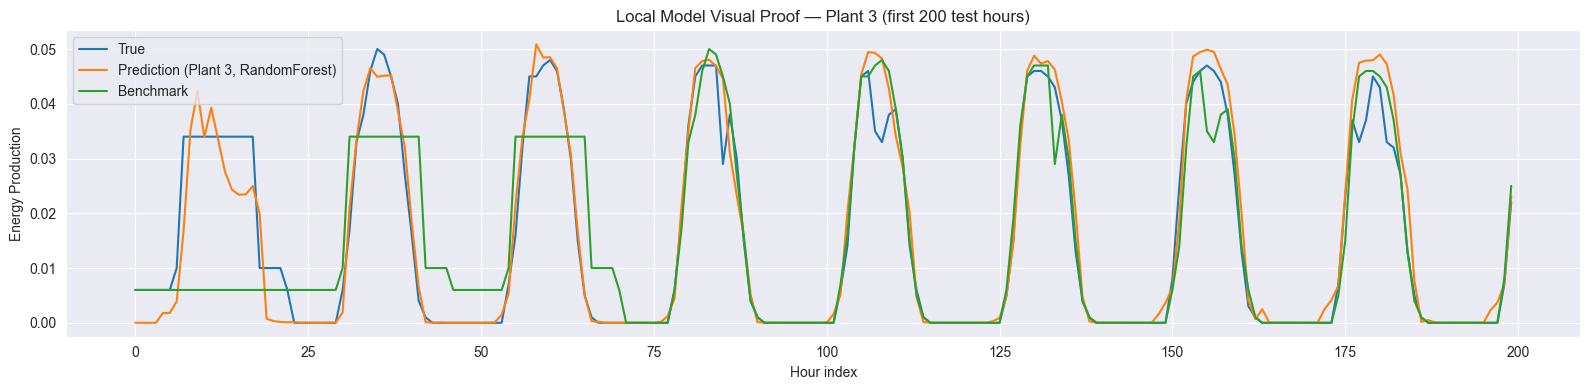

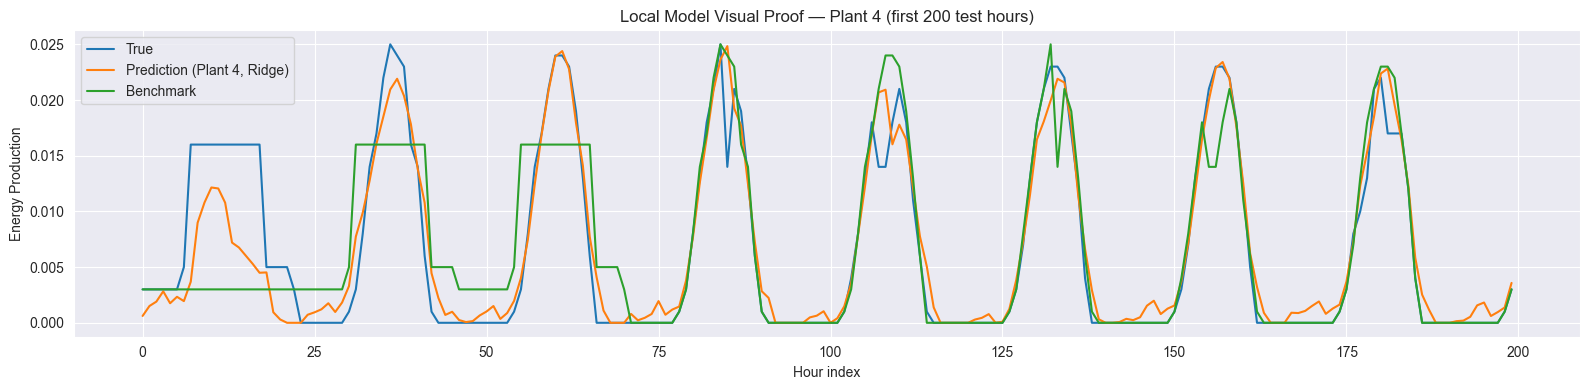

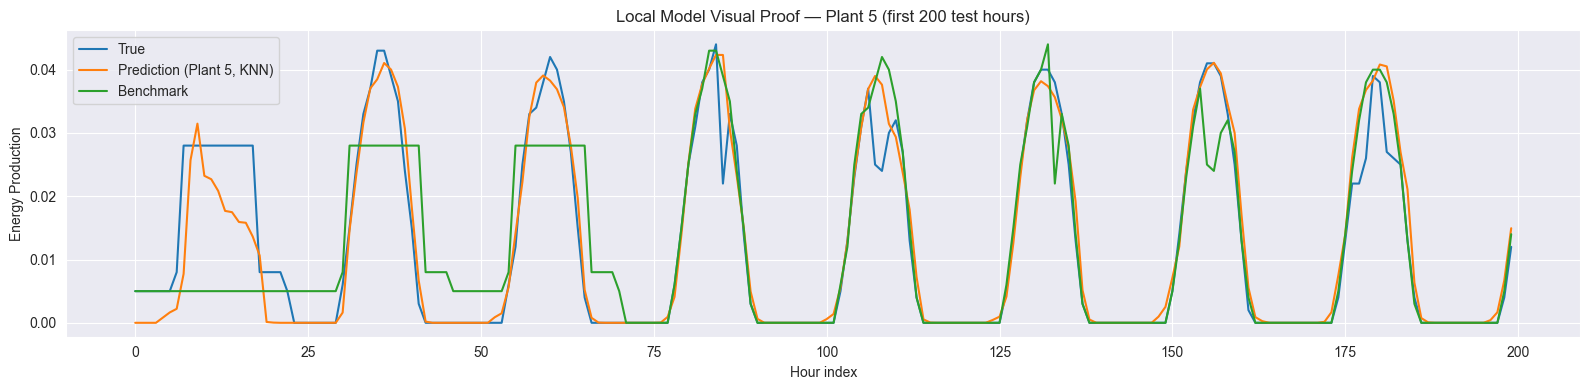

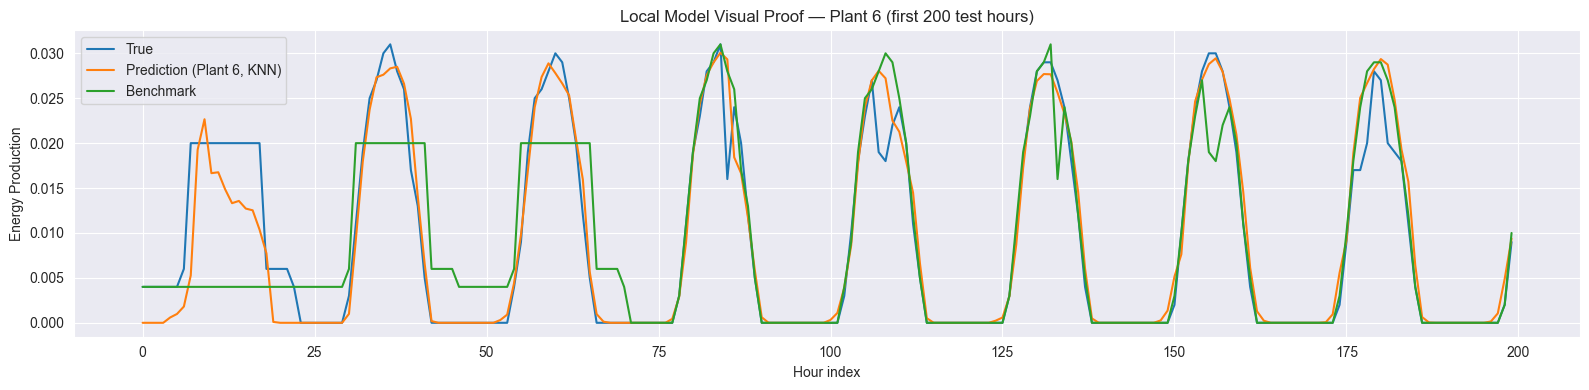

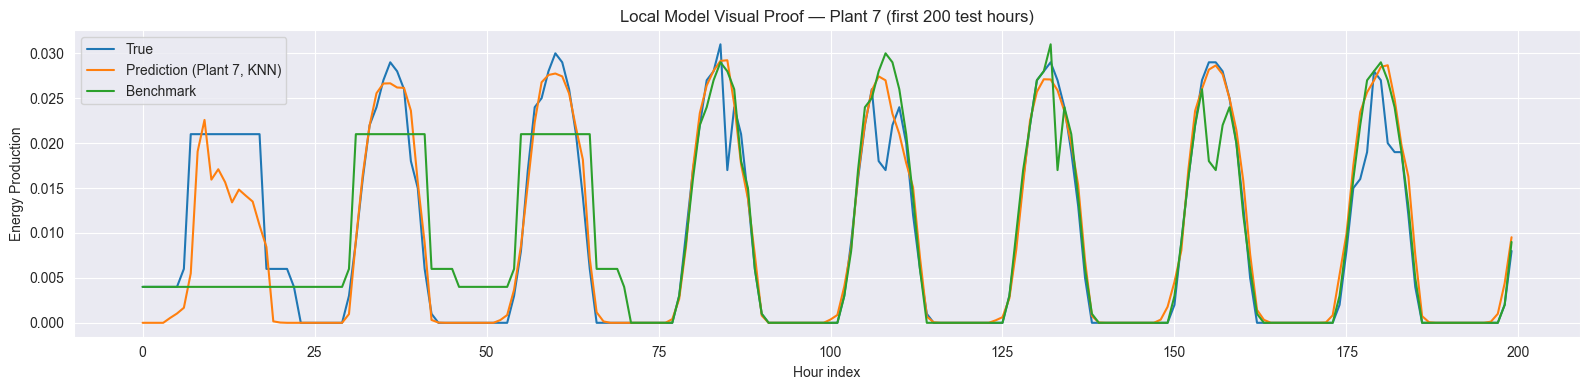

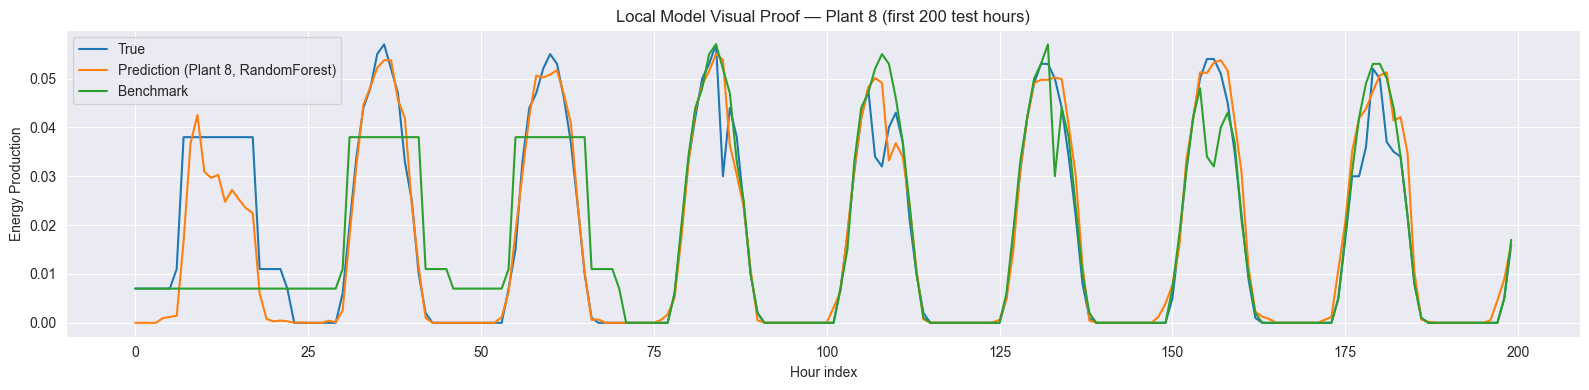

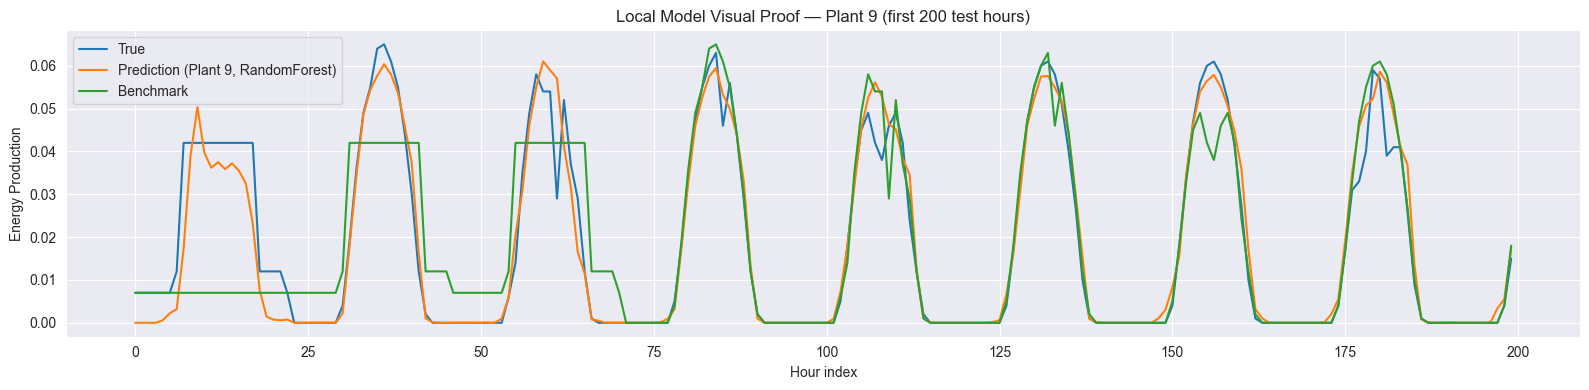

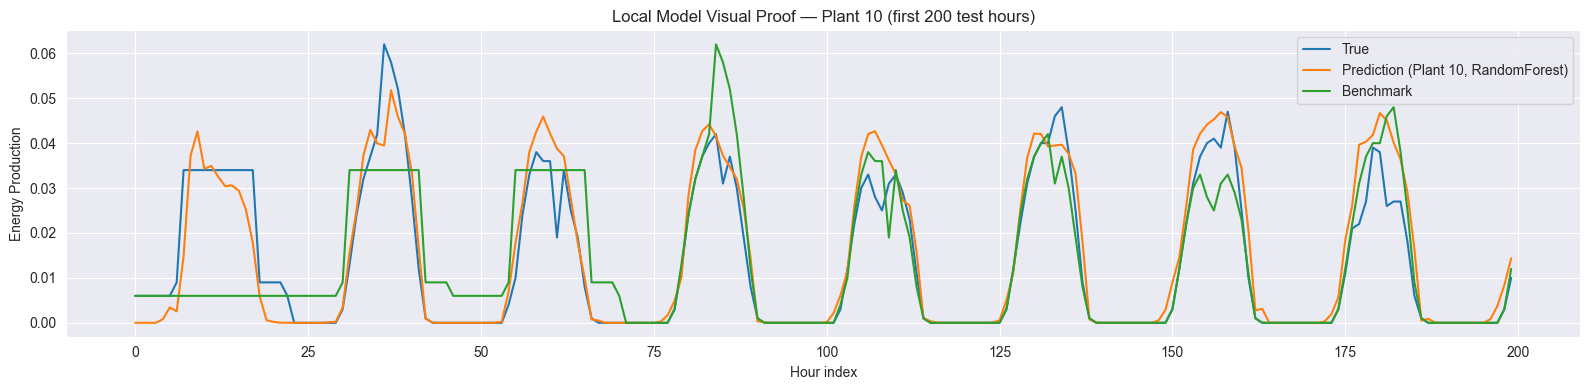

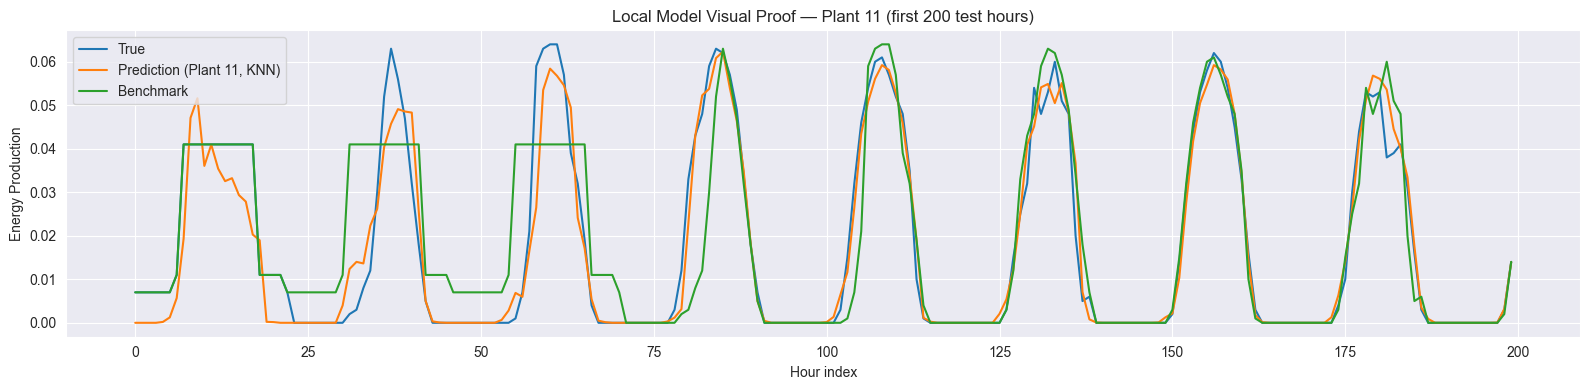

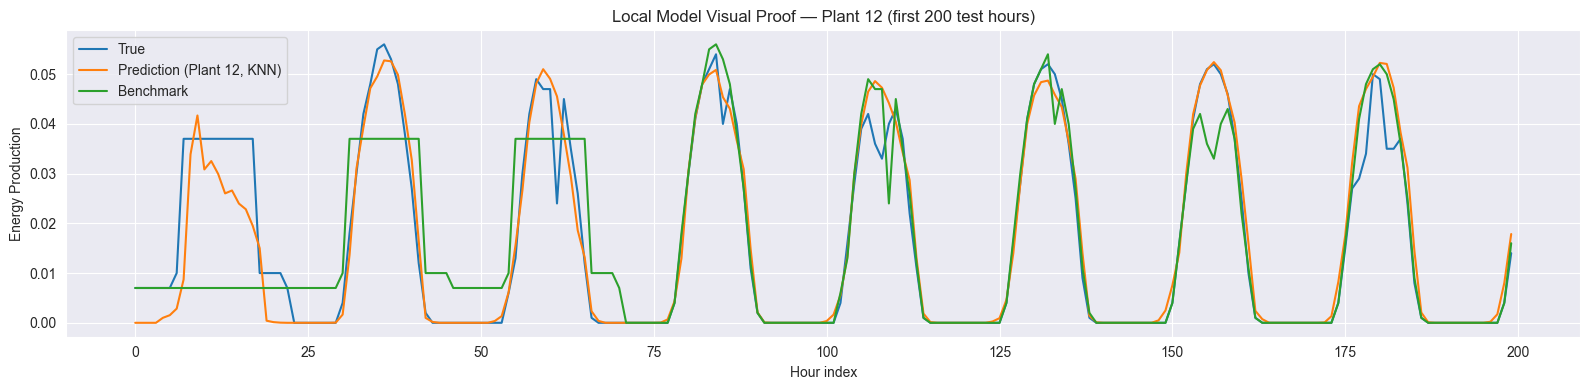

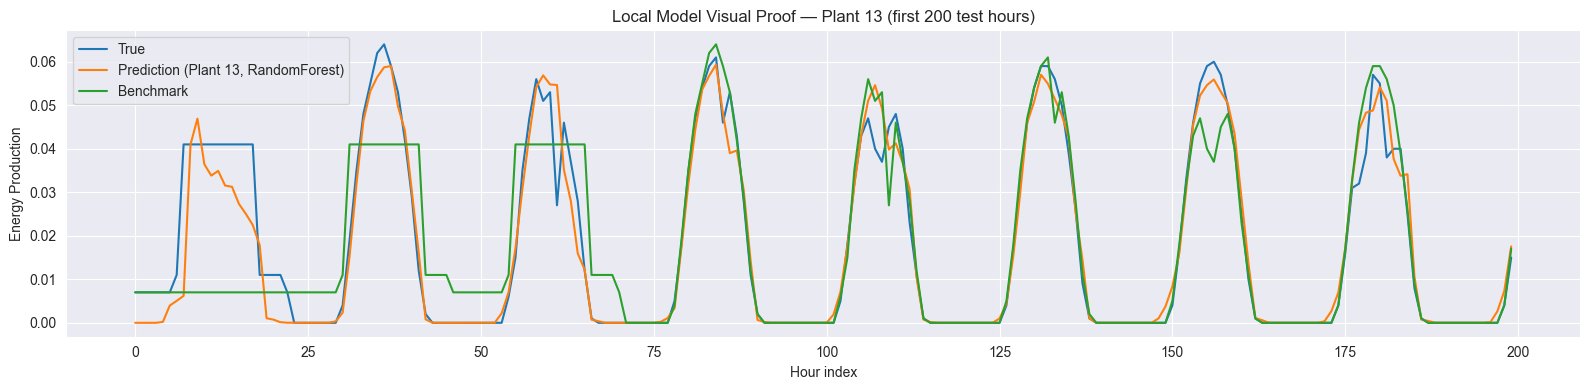

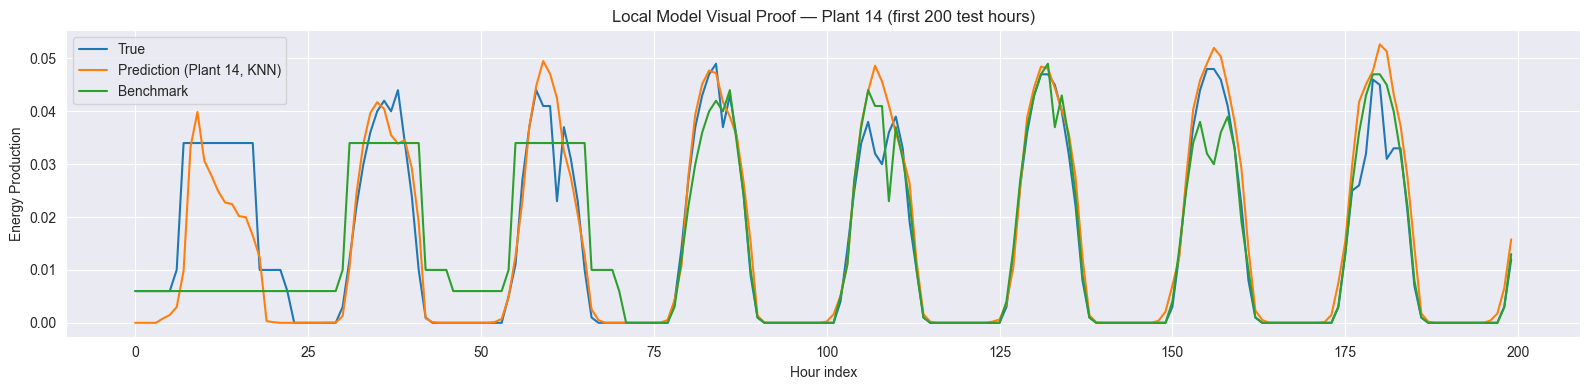

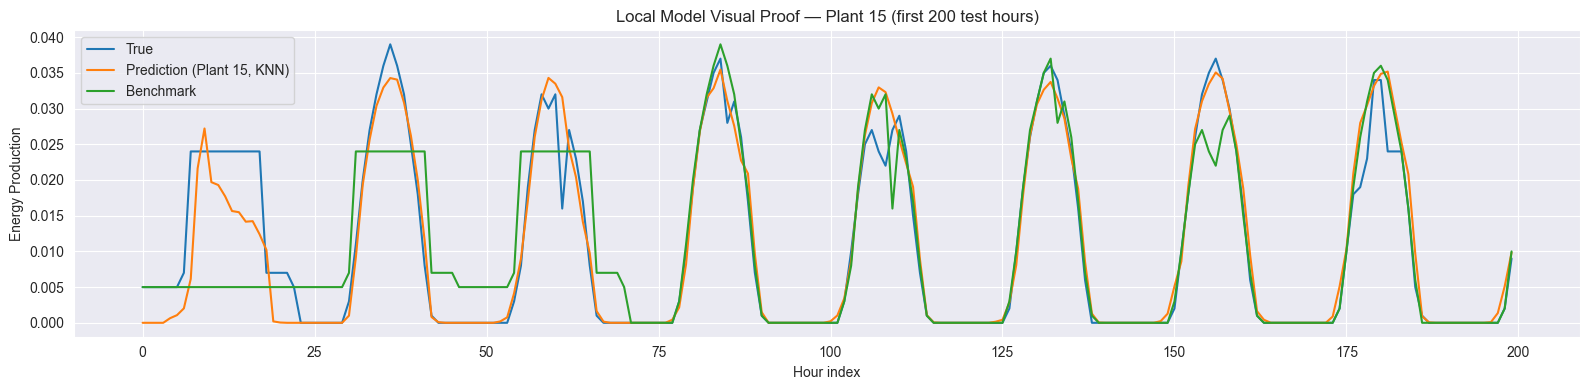

In [52]:
# Plot "visual proof" for EVERY plant using its best local model
n = 200  # first n test hours per plant

for pid in sorted(best_local_per_plant["Plant_ID"].unique()):
    # best model for this plant
    best_model_for_pid = best_local_per_plant.loc[
        best_local_per_plant["Plant_ID"] == pid, "model"
    ].iloc[0]
    model_name = best_model_for_pid.replace("Local-", "")

    key = (pid, model_name)
    if key not in local_test_predictions:
        print(f"Missing predictions for Plant {pid}, model {model_name}. Skipping.")
        continue

    pack = local_test_predictions[key]

    # sort by time for clean plot
    order = np.argsort(pack["utc_time"])
    y_true = pack["y_true"][order]
    y_pred = pack["y_pred"][order]
    y_bench = pack["benchmark"][order] if pack["benchmark"] is not None else None

    nn = min(n, len(y_true))

    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(y_true[:nn], label="True")
    ax.plot(y_pred[:nn], label=f"Prediction (Plant {pid}, {model_name})")
    if y_bench is not None:
        ax.plot(y_bench[:nn], label="Benchmark")

    ax.set_title(f"Local Model Visual Proof — Plant {pid} (first {nn} test hours)")
    ax.set_xlabel("Hour index")
    ax.set_ylabel("Energy Production")
    ax.legend()
    plt.tight_layout()
    plt.show()


In [56]:
rmse_table = (
    best_local_per_plant[
        [
            "Plant_ID",
            "model",
            "rmse_train",
            "rmse_test",
            "r2_train",
            "r2_test"
        ]
    ]
    .assign(
        rmse_gap=lambda d: d["rmse_test"] - d["rmse_train"],
        r2_gap=lambda d: d["r2_train"] - d["r2_test"]
    )
    .sort_values("rmse_test")
    .reset_index(drop=True)
)

display(rmse_table)


,Plant_ID,model,rmse_train,rmse_test,r2_train,r2_test,rmse_gap,r2_gap
0,4,Local-Ridge,2.262371e-03,0.001708,0.925222,0.859250,-0.000554,0.065972
1,7,Local-KNN,2.178409e-09,0.001837,1.000000,0.917805,0.001837,0.082195
2,6,Local-KNN,2.175161e-09,0.002236,1.000000,0.897702,0.002236,0.102298
3,0,Local-KNN,1.367863e-09,0.002246,1.000000,0.923000,0.002246,0.077000
4,15,Local-KNN,2.451286e-09,0.002472,1.000000,0.915335,0.002472,0.084665
5,5,Local-KNN,3.337730e-09,0.002779,1.000000,0.910624,0.002779,0.089376
6,1,Local-RandomForest,1.339752e-03,0.003036,0.991850,0.898765,0.001696,0.093085
7,12,Local-KNN,3.654053e-09,0.003762,1.000000,0.915097,0.003762,0.084903
8,14,Local-KNN,3.724589e-09,0.003819,1.000000,0.896119,0.003819,0.103881
9,2,Local-KNN,1.654833e-09,0.003955,1.000000,0.869374,0.003955,0.130626


rmse_train    0.000722
rmse_test     0.003367
r2_train      0.992342
r2_test       0.901755
dtype: float64

# Part 4 — Model Interpretation (XAI)

We provide both:

## Global interpretation
- **Permutation Importance**: model-agnostic feature importance measured by performance drop when a feature is shuffled.
- **SHAP (global)**: identifies the most influential drivers and shows the direction of their effect.

## Local interpretation
- **SHAP (local)**: explains a single prediction (e.g., peak production or a large-error anomaly) by decomposing the prediction into feature contributions.

Important note with PCA:
- Some drivers become **PCA components** (PC1, PC2, …). These represent combinations of the original weather variables.
- Lag/rolling features and cyclical features remain directly interpretable.


Best GLOBAL model: RandomForest


,feature,importance_mean,importance_std
1,Day-Night,0.003370,0.000083
25,EP_roll_std_3,0.000925,0.000037
21,Energy_Production_lag_6,0.000714,0.000029
14,hour,0.000690,0.000036
15,hour_sin,0.000674,0.000062
27,EP_roll_std_6,0.000611,0.000018
19,Energy_Production_lag_1,0.000533,0.000032
23,Energy_Production_lag_24,0.000443,0.000054
29,EP_roll_std_12,0.000314,0.000016
24,EP_roll_mean_3,0.000306,0.000018


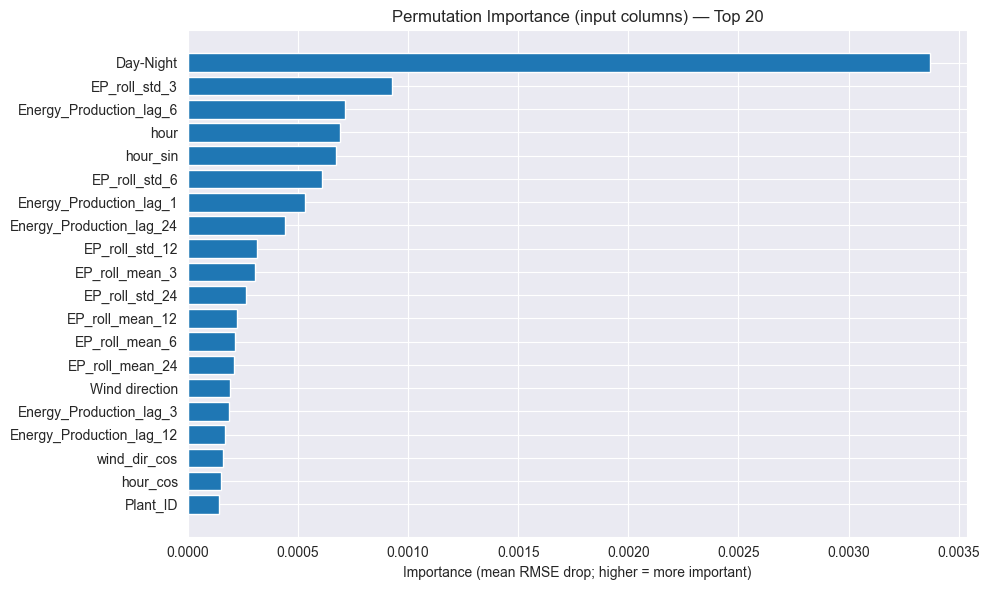

In [ ]:
import numpy as np

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.inspection import permutation_importance


# -----------------------------
# ASSUMES THESE EXIST (from your notebook):
# results_all, models, param_grids, X_train, y_train, X_test, y_test
# local_results_df, local_models, local_param_grids, local_feature_cols
# train_feat, test_feat, TARGET_COL, TIME_COL, BENCH_COL, PLANT_COL
# -----------------------------

# -----------------------------
# Helpers
# -----------------------------
def safe_subsample(X, y, n=3000, seed=42):
    n = min(n, len(X))
    rng = np.random.RandomState(seed)
    idx = rng.choice(len(X), size=n, replace=False)
    return X.iloc[idx], y.iloc[idx]


def is_tree_model(m):
    return m.__class__.__name__ in ["RandomForestRegressor", "GradientBoostingRegressor"]


def make_perm_importance_df(perm, X_input, top_k=20):
    """
    IMPORTANT:
    permutation_importance permutes ORIGINAL INPUT COLUMNS of X_input,
    so feature names MUST be X_input.columns (not transformed feature names).
    """
    feat_names = np.array(X_input.columns, dtype=str)
    imp_df = pd.DataFrame({
        "feature": feat_names,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std
    }).sort_values("importance_mean", ascending=False)

    display(imp_df.head(top_k))

    plot_df = imp_df.head(top_k).iloc[::-1]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(plot_df["feature"], plot_df["importance_mean"])
    ax.set_title(f"Permutation Importance (input columns) — Top {top_k}")
    ax.set_xlabel("Importance (mean RMSE drop; higher = more important)")
    plt.tight_layout()
    plt.show()

    return imp_df


# -----------------------------
# 0) Best local per plant (if missing)
# -----------------------------
if "best_local_per_plant" not in globals():
    best_local_per_plant = (
        local_results_df
        .sort_values([PLANT_COL, "rmse_test"])
        .groupby(PLANT_COL, as_index=False)
        .first()
    )

# -----------------------------
# 1) GLOBAL: pick best model and refit (safe)
# -----------------------------
best_global_name = results_all[results_all["model"] != "Benchmark"].iloc[0]["model"]
print("Best GLOBAL model:", best_global_name)

best_global_pipe = GridSearchCV(
    models[best_global_name],
    param_grids[best_global_name],
    scoring="neg_root_mean_squared_error",
    cv=TimeSeriesSplit(n_splits=3),
    n_jobs=1,  # SAFE (no loky crash)
    error_score="raise"
).fit(X_train, y_train).best_estimator_

# Avoid nested parallelism
try:
    if best_global_pipe.named_steps["model"].__class__.__name__ == "RandomForestRegressor":
        best_global_pipe.named_steps["model"].set_params(n_jobs=1)
except Exception:
    pass

prep_g = best_global_pipe.named_steps["prep"]
model_g = best_global_pipe.named_steps["model"]

# -----------------------------
# 2) GLOBAL: Permutation Importance (FIXED feature names)
# -----------------------------
X_pi, y_pi = safe_subsample(X_test, y_test, n=2500, seed=42)

perm = permutation_importance(
    best_global_pipe,
    X_pi,
    y_pi,
    scoring="neg_root_mean_squared_error",
    n_repeats=3,
    random_state=42,
    n_jobs=1,  # CRITICAL for macOS stability
    max_samples=0.7
)

imp_df_global = make_perm_importance_df(perm, X_pi, top_k=20)

# -----------------------------
# 3) GLOBAL: SHAP (summary + direction)
# -----------------------------
import shap

X_shap, y_shap = safe_subsample(X_test, y_test, n=1200, seed=7)
X_shap_trans = prep_g.transform(X_shap)

# feature names AFTER preprocessing (for SHAP plots only)
try:
    feat_names_trans_g = prep_g.get_feature_names_out()
except Exception:
    feat_names_trans_g = [f"f{i}" for i in range(X_shap_trans.shape[1])]

if is_tree_model(model_g):
    expl_g = shap.TreeExplainer(model_g)
    sv_g = expl_g.shap_values(X_shap_trans)
    shap.summary_plot(sv_g, X_shap_trans, feature_names=feat_names_trans_g, plot_type="bar", max_display=20)
    shap.summary_plot(sv_g, X_shap_trans, feature_names=feat_names_trans_g, max_display=20)
else:
    bg = X_shap_trans[:200]
    expl_g = shap.Explainer(model_g, bg)
    sv_g = expl_g(X_shap_trans)
    shap.summary_plot(sv_g, feature_names=feat_names_trans_g, plot_type="bar", max_display=20)
    shap.summary_plot(sv_g, feature_names=feat_names_trans_g, max_display=20)

# -----------------------------
# 4) GLOBAL: Local SHAP for biggest absolute error
# -----------------------------
y_pred_test_g = np.clip(best_global_pipe.predict(X_test), 0, None)
abs_err_g = np.abs(y_test.values - y_pred_test_g)
idx_anom_g = int(np.argmax(abs_err_g))

print("GLOBAL anomaly idx:", idx_anom_g,
      "| y_true:", float(y_test.values[idx_anom_g]),
      "| y_pred:", float(y_pred_test_g[idx_anom_g]),
      "| abs_err:", float(abs_err_g[idx_anom_g]))

x_row_g = X_test.iloc[[idx_anom_g]]
x_row_trans_g = prep_g.transform(x_row_g)

try:
    if is_tree_model(model_g):
        sv_row = expl_g.shap_values(x_row_trans_g)
        base_val = expl_g.expected_value
        exp_g = shap.Explanation(
            values=sv_row[0] if isinstance(sv_row, list) else sv_row[0],
            base_values=base_val if np.isscalar(base_val) else base_val[0],
            data=x_row_trans_g[0],
            feature_names=feat_names_trans_g
        )
        shap.plots.waterfall(exp_g)
    else:
        exp_g = expl_g(x_row_trans_g)
        shap.plots.waterfall(exp_g[0])
except Exception as e:
    print("GLOBAL local SHAP failed:", repr(e))

# -----------------------------
# 5) LOCAL: choose plant, refit BEST local model (always use local_models)
# -----------------------------
pid = 0  # change if needed

best_local_label = best_local_per_plant.loc[best_local_per_plant[PLANT_COL] == pid, "model"].iloc[0]
best_local_name = best_local_label.replace("Local-", "")
print(f"Best LOCAL model for Plant {pid}:", best_local_name)

tr_p = train_feat[train_feat[PLANT_COL] == pid].sort_values(TIME_COL)
te_p = test_feat[test_feat[PLANT_COL] == pid].sort_values(TIME_COL)

X_tr_local = tr_p[local_feature_cols].copy()
y_tr_local = tr_p[TARGET_COL].copy()
X_te_local = te_p[local_feature_cols].copy()
y_te_local = te_p[TARGET_COL].copy()

best_local_pipe = GridSearchCV(
    local_models[best_local_name],  # CRITICAL: local pipeline (no Plant_ID expected)
    local_param_grids[best_local_name],
    scoring="neg_root_mean_squared_error",
    cv=TimeSeriesSplit(n_splits=3),
    n_jobs=1,
    error_score="raise"
).fit(X_tr_local, y_tr_local).best_estimator_

try:
    if best_local_pipe.named_steps["model"].__class__.__name__ == "RandomForestRegressor":
        best_local_pipe.named_steps["model"].set_params(n_jobs=1)
except Exception:
    pass

prep_l = best_local_pipe.named_steps["prep"]
model_l = best_local_pipe.named_steps["model"]

# -----------------------------
# 6) LOCAL: SHAP (summary + local explanation)
# -----------------------------
X_local_shap, y_local_shap = safe_subsample(X_te_local, y_te_local, n=800, seed=11)
X_local_trans = prep_l.transform(X_local_shap)

try:
    feat_names_trans_l = prep_l.get_feature_names_out()
except Exception:
    feat_names_trans_l = [f"f{i}" for i in range(X_local_trans.shape[1])]

if is_tree_model(model_l):
    expl_l = shap.TreeExplainer(model_l)
    sv_l = expl_l.shap_values(X_local_trans)
    shap.summary_plot(sv_l, X_local_trans, feature_names=feat_names_trans_l, plot_type="bar", max_display=20)
    shap.summary_plot(sv_l, X_local_trans, feature_names=feat_names_trans_l, max_display=20)
else:
    bg_l = X_local_trans[:200]
    expl_l = shap.Explainer(model_l, bg_l)
    sv_l = expl_l(X_local_trans)
    shap.summary_plot(sv_l, feature_names=feat_names_trans_l, plot_type="bar", max_display=20)
    shap.summary_plot(sv_l, feature_names=feat_names_trans_l, max_display=20)

# Local anomaly index
y_pred_l = np.clip(best_local_pipe.predict(X_te_local), 0, None)
abs_err_l = np.abs(y_te_local.values - y_pred_l)
idx_anom_l = int(np.argmax(abs_err_l))

print(f"LOCAL anomaly idx (Plant {pid}):", idx_anom_l,
      "| y_true:", float(y_te_local.values[idx_anom_l]),
      "| y_pred:", float(y_pred_l[idx_anom_l]),
      "| abs_err:", float(abs_err_l[idx_anom_l]))

x_row_l = X_te_local.iloc[[idx_anom_l]]
x_row_trans_l = prep_l.transform(x_row_l)

try:
    if is_tree_model(model_l):
        sv_row_l = expl_l.shap_values(x_row_trans_l)
        base_val_l = expl_l.expected_value
        exp_l = shap.Explanation(
            values=sv_row_l[0] if isinstance(sv_row_l, list) else sv_row_l[0],
            base_values=base_val_l if np.isscalar(base_val_l) else base_val_l[0],
            data=x_row_trans_l[0],
            feature_names=feat_names_trans_l
        )
        shap.plots.waterfall(exp_l)
    else:
        exp_l = expl_l(x_row_trans_l)
        shap.plots.waterfall(exp_l[0])
except Exception as e:
    print("LOCAL local SHAP failed:", repr(e))


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# -------------------------
# Inputs expected from your notebook
# -------------------------
# best_global_pipe: fitted pipeline
# X_test, y_test: global test set

# Permutation importance on test (model-agnostic)
perm = permutation_importance(
    best_global_pipe,
    X_test,
    y_test,
    scoring="neg_root_mean_squared_error",
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Try to recover readable feature names (including OneHot + PCA component names)
feature_names = None
try:
    # best_global_pipe is Pipeline(["prep", "model"])
    prep = best_global_pipe.named_steps["prep"]
    feature_names = prep.get_feature_names_out()
except Exception:
    feature_names = np.array(X_test.columns)

imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

display(imp_df.head(20))

# Plot top 20
top_k = 20
plot_df = imp_df.head(top_k).iloc[::-1]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(plot_df["feature"], plot_df["importance_mean"])
ax.set_title(f"Permutation Importance (Test RMSE drop) — Top {top_k}")
ax.set_xlabel("Importance (mean RMSE drop; higher = more important)")
plt.tight_layout()
plt.show()

4B) Global — SHAP

In [ ]:
# SHAP (global): robust for Pipeline with preprocessing + PCA
# If shap is not installed, run: pip install shap
import shap

# 1) Separate preprocessor and final model
prep = best_global_pipe.named_steps["prep"]
model = best_global_pipe.named_steps["model"]

# 2) Transform data
X_test_trans = prep.transform(X_test)

# 3) Feature names after preprocessing (includes PCA components and OneHot)
try:
    feat_names_trans = prep.get_feature_names_out()
except Exception:
    feat_names_trans = [f"f{i}" for i in range(X_test_trans.shape[1])]

# 4) Choose explainer depending on model type
# TreeExplainer works best for RandomForest/GradientBoosting; otherwise fallback to generic Explainer.
try:
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_trans)
except Exception:
    # Generic (works widely, may be slower)
    explainer = shap.Explainer(model, X_test_trans)
    shap_values = explainer(X_test_trans)

# 5) SHAP summary plots
# shap_values can be list/array or Explanation depending on explainer
# Standardize to "values" and "data" for plotting
if isinstance(shap_values, shap._explanation.Explanation):
    sv = shap_values
    X_for_plot = sv.data
else:
    sv = shap_values
    X_for_plot = X_test_trans

# Global importance (bar)
shap.summary_plot(sv, X_for_plot, feature_names=feat_names_trans, plot_type="bar", max_display=20)

# Directional impact (beeswarm)
shap.summary_plot(sv, X_for_plot, feature_names=feat_names_trans, max_display=20)

4C) Local

In [ ]:
# Pick an interesting instance in the GLOBAL test set
y_pred_test = np.clip(best_global_pipe.predict(X_test), 0, None)
abs_err = np.abs(y_test.values - y_pred_test)

idx_peak = int(np.argmax(y_test.values))
idx_anom = int(np.argmax(abs_err))

print("Peak index:", idx_peak, "| y_true:", y_test.values[idx_peak], "| y_pred:", y_pred_test[idx_peak])
print("Anom index:", idx_anom, "| y_true:", y_test.values[idx_anom], "| y_pred:", y_pred_test[idx_anom], "| abs_err:",
      abs_err[idx_anom])

# Choose one to explain
idx = idx_anom  # change to idx_peak if you prefer peak explanation

# Transform the single row through preprocessing
x_row = X_test.iloc[[idx]]
x_row_trans = prep.transform(x_row)

# Explain using same explainer type as above
try:
    explainer_local = shap.TreeExplainer(model)
    sv_row = explainer_local.shap_values(x_row_trans)
    # Build an Explanation object for waterfall plot (manual)
    base_value = explainer_local.expected_value
    # For regression, expected_value is scalar
    exp = shap.Explanation(
        values=sv_row[0] if isinstance(sv_row, list) else sv_row[0],
        base_values=base_value if np.isscalar(base_value) else base_value[0],
        data=x_row_trans[0],
        feature_names=feat_names_trans
    )
except Exception:
    explainer_local = shap.Explainer(model, X_test_trans)
    exp = explainer_local(x_row_trans)

# Waterfall plot (local explanation)
shap.plots.waterfall(exp[0] if isinstance(exp, shap._explanation.Explanation) else exp)

4D) Local — SHAP for a plant-specific model

In [ ]:
import shap

# Separate local preprocessor and model
prep_local = best_local_pipe.named_steps["prep"]
model_local = best_local_pipe.named_steps["model"]

X_te_local_trans = prep_local.transform(X_te_local)

try:
    feat_names_local = prep_local.get_feature_names_out()
except Exception:
    feat_names_local = [f"f{i}" for i in range(X_te_local_trans.shape[1])]

# Choose an interesting local instance
y_pred_local = np.clip(best_local_pipe.predict(X_te_local), 0, None)
abs_err_local = np.abs(y_te_local.values - y_pred_local)

idx_local_peak = int(np.argmax(y_te_local.values))
idx_local_anom = int(np.argmax(abs_err_local))

print(f"[Plant {pid}] Peak idx:", idx_local_peak, "| y_true:", y_te_local.values[idx_local_peak], "| y_pred:",
      y_pred_local[idx_local_peak])
print(f"[Plant {pid}] Anom idx:", idx_local_anom, "| y_true:", y_te_local.values[idx_local_anom], "| y_pred:",
      y_pred_local[idx_local_anom], "| abs_err:", abs_err_local[idx_local_anom])

idx = idx_local_anom  # switch to idx_local_peak if desired

x_row_local = X_te_local.iloc[[idx]]
x_row_local_trans = prep_local.transform(x_row_local)

# SHAP explainer
try:
    explainer_l = shap.TreeExplainer(model_local)
    sv_row_l = explainer_l.shap_values(x_row_local_trans)
    base_value_l = explainer_l.expected_value

    exp_l = shap.Explanation(
        values=sv_row_l[0] if isinstance(sv_row_l, list) else sv_row_l[0],
        base_values=base_value_l if np.isscalar(base_value_l) else base_value_l[0],
        data=x_row_local_trans[0],
        feature_names=feat_names_local
    )
except Exception:
    explainer_l = shap.Explainer(model_local, X_te_local_trans)
    exp_l = explainer_l(x_row_local_trans)

shap.plots.waterfall(exp_l[0] if isinstance(exp_l, shap._explanation.Explanation) else exp_l)